## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalConstants,
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    

Declare reward function used in training for cost

In [5]:
def rewardFnCost(outputDifferentialFromOpt):
    baseComponent = 2**(-(outputDifferentialFromOpt**2)/100)
    peakComponent = 2**(-(outputDifferentialFromOpt**2)/2)
    earnedReward = (baseComponent + 9*peakComponent)/10
    
#     print(f'outputDifferentialFromOpt:{outputDifferentialFromOpt} - baseComponent:{baseComponent} - peakComponent:{peakComponent} - reward:{earnedReward}')

    return earnedReward, {'base': baseComponent, 'peak': peakComponent, 'total':earnedReward}

from learning.cost_single import ModelAdapterCostSingle as ModelAdapterCost
modelAdapterCost = ModelAdapterCost(rewardFn=rewardFnCost)

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Declare reward function used in training for frequency

In [6]:
def rewardFnFrequency(deltaFreq):
    baseComponent = 2**(-(deltaFreq**2)/100)
    peakComponent = 2**(-(deltaFreq**2)/2)
    earnedReward = (baseComponent + 9*peakComponent)/10

    return earnedReward, {'base': baseComponent, 'peak': peakComponent, 'total':earnedReward}

from learning.frequency import ModelAdapterFrequency
modelAdapterFrequency = ModelAdapterFrequency(rewardFn=rewardFnFrequency)

In [7]:
from learning import LearningParams

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=15000, # Number of learning episodes to run
    maxSteps=200,   # Number of steps per learning episode
    traceLength=8,     # Number of steps each sampled episode should contain
    batchSize=4,     # Number of episodes sampled from experience buffer
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.01)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
        ],
        shouldTrackOptimalCost=True,
    ),
#     modelName='Test-Cost_Learning-No_Droop-65'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.01)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=3.0, noiseLevel=0.005)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=15000, maxSteps=200, bufferSize=100, traceLength=8, batchSize=4, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), explorationNoiseSize=0.4, actionScale=0.1, modelNam

In [8]:
from learning import ModelTesterActionComposition
import matplotlib.pyplot as plt
from plots import plotAll, plotRewardComponents
from plots.observed_power_plot import plotObservedPowerZoomed


STEPS_TO_TEST = 100

modelTester = ModelTesterActionComposition(
    modelAdapterFreq=modelAdapterFrequency,
    modelAdapterCost=modelAdapterCost,
)

def runTest(frequencyWeight):
    # Run test episode
    electricalSystem, allRewards, rewardComponents = modelTester.testAgents(
        electricalSystemSpecs=LearningParams().electricalSystemSpecs, 
        modelNameFreq='Experiment_I-Frequency-15k',  
        modelNameCost='Experiment_III-Cost-15k',
        stepsToTest=STEPS_TO_TEST, 
        frequencyWeight=frequencyWeight,
    )
    
    # Plot reward components progression per model
    for modelName, rewardComp in rewardComponents.items():
        print(modelName)
        plotRewardComponents(rewardComp)
        
    # Plot standard experiment progression plots
    plotAll(electricalSystem.systemHistory)
    
    
    plotObservedPowerZoomed(electricalSystem.systemHistory)
    
    



## 70% Frequency - 30% Cost
Run experiment with action = 0.7\*Frequency + 0.3\*Cost

W1013 18:13:25.514731 140025524193024 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1013 18:13:25.515380 140025524193024 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W1013 18:13:25.528230 140025524193024 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

frequency


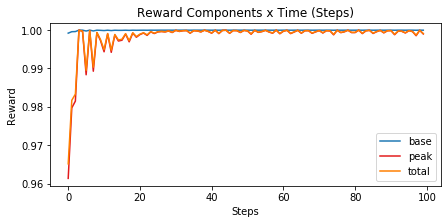

cost


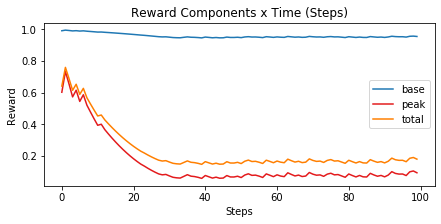

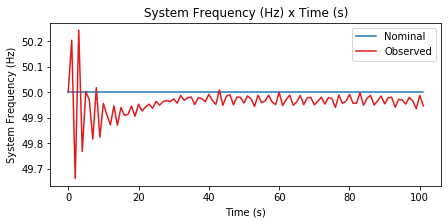

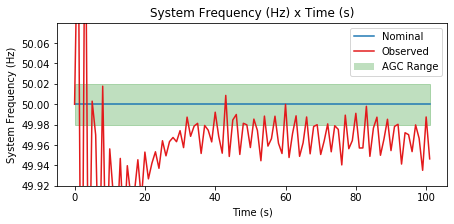

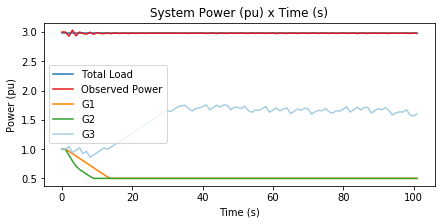

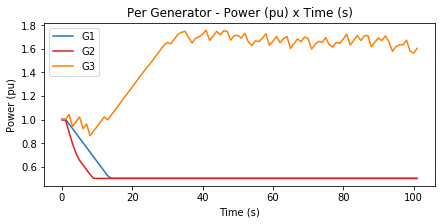

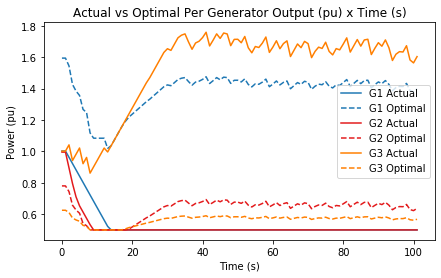

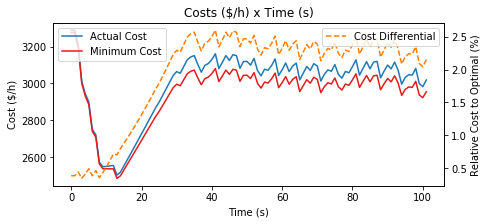

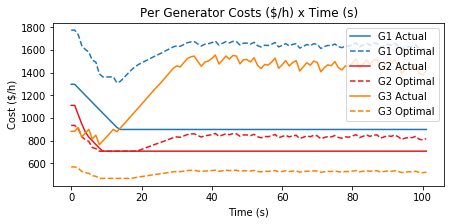

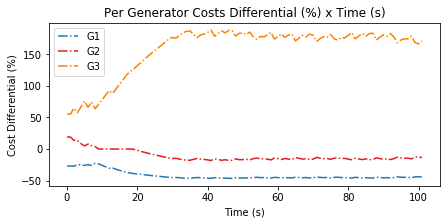

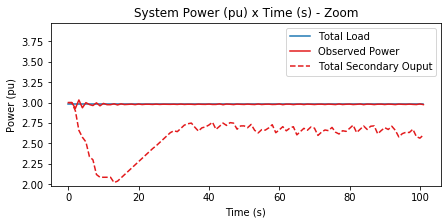

In [9]:
runTest(frequencyWeight=0.7)

## 50% Frequency - 50% Cost

Action = 0.5\*Frequency + 0.5\*Cost

frequency


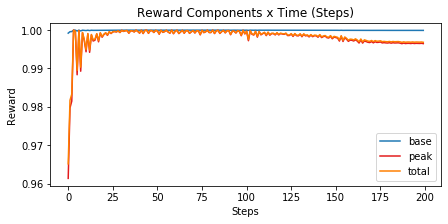

cost


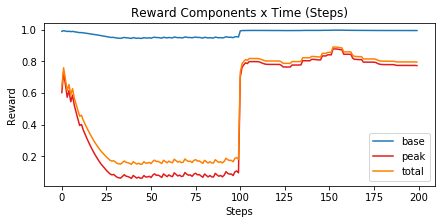

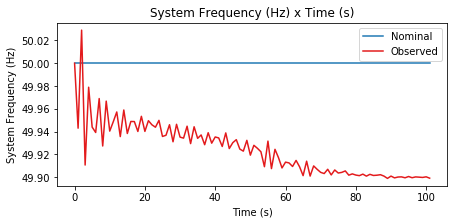

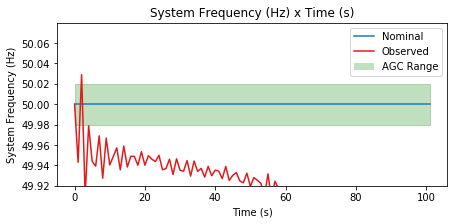

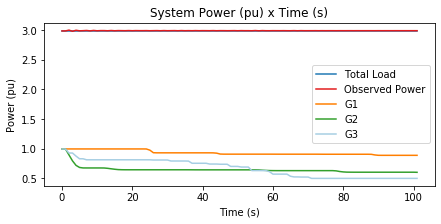

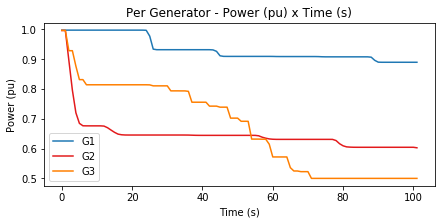

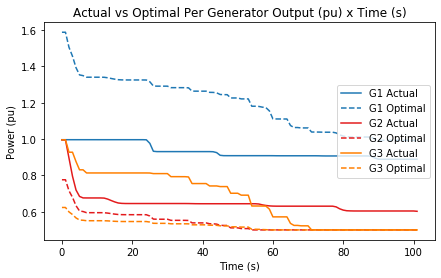

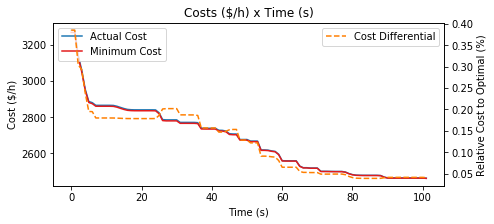

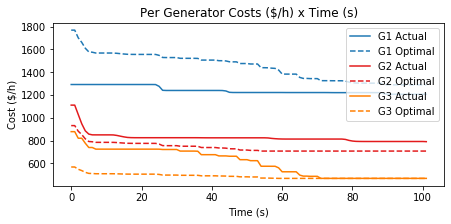

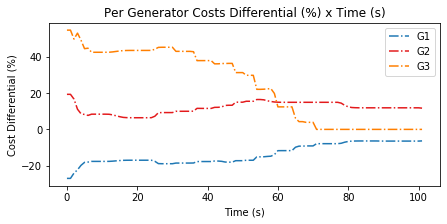

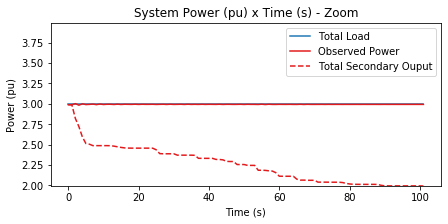

In [10]:
runTest(frequencyWeight=0.5)

## 30% Frequency - 70% Cost
Run experiment with action = 0.3\*Frequency + 0.7\*Cost

frequency


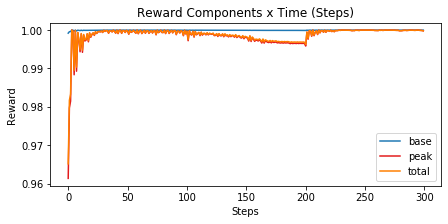

cost


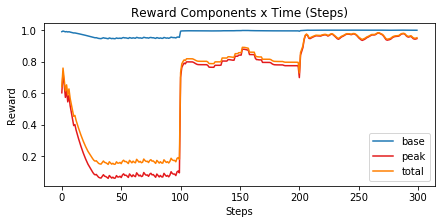

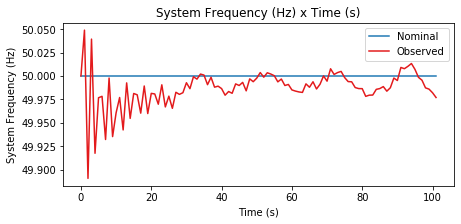

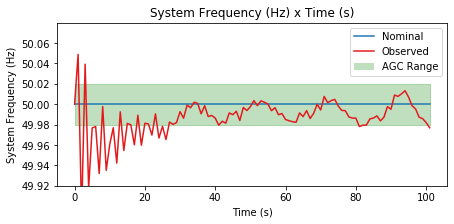

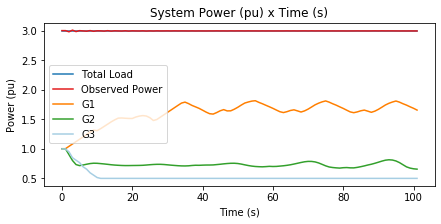

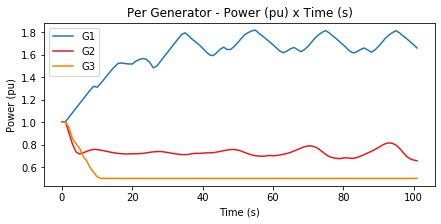

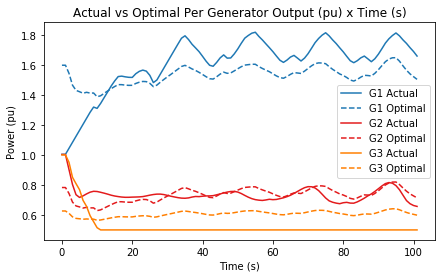

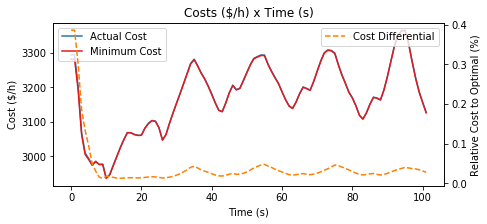

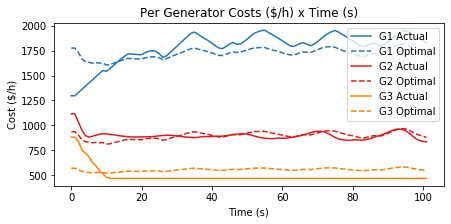

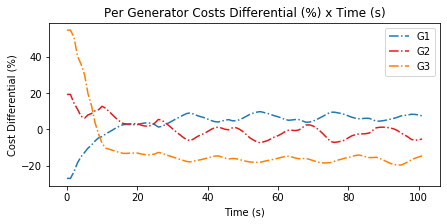

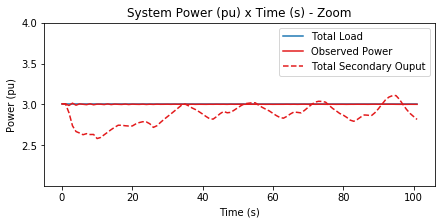

In [11]:
runTest(frequencyWeight=0.3)